In [1]:
from configs.config import get_path
import src.utils.gen_jobs as gen_jobs
import src.utils.gen_deadline as gen_deadline

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
pd.set_option('display.max_rows', 26)


In [2]:
import src.utils.gen_interarrival as gen_ta
import math
import numpy as np

In [3]:
basic_data_path = get_path("data", "basic")
df_instance = pd.read_csv(basic_data_path / "00_instance.csv")

arrival_shifts_numb = 10
df_jssp, df_jobs_times = gen_jobs.create_jobs_for_shifts(df_instance, shift_count= arrival_shifts_numb, u_b_mmax= 0.94, 
                                                         shift_length = 1440, shuffle = True, job_seed= 50, arrival_seed = 120)
df_jobs_times

,Job,Arrival,Ready Time,Processing Time,Earliest End
0,Job_000,0,1440,395,1835
1,Job_001,48,1440,510,1950
2,Job_002,113,1440,568,2008
3,Job_003,157,1440,655,2095
4,Job_004,198,1440,393,1833
...,...,...,...,...,...
213,Job_213,14045,14400,416,14816
214,Job_214,14107,14400,540,14940
215,Job_215,14297,14400,510,14910
216,Job_216,14360,14400,568,14968


### I) Log-Normalverteilung 
#### - mit Sigma als frei wählbarer Parameter
#### - min. Deadline = "Earliest End"
#### - Erwartungswert (Median) der Lognormalverteilung = "Earliest End"

In [4]:
def assign_log_normal_deadlines(df, sigma=0.5, seed=120):
    """
    Fügt dem DataFrame eine 'Deadline'-Spalte hinzu, basierend auf einer Lognormalverteilung.
    Die Deadline ist mindestens 'Ready Time' + 'Processing Time' und wird aufgerundet.

    Erwartete Spalten: 'Earliest End', 'Ready Time', 'Processing Time'
    """
    np.random.seed(seed)

    log_means = np.log(df["Earliest End"]) - 0.5 * sigma**2
    sampled_deadlines = np.random.lognormal(mean=log_means, sigma=sigma)
    min_deadlines = df["Earliest End"]
    deadlines = np.ceil(np.maximum(sampled_deadlines, min_deadlines))

    df = df.copy()
    df["Deadline"] = deadlines.astype(int)
    return df


In [5]:
assign_log_normal_deadlines(df_jobs_times, sigma=0.5)

,Job,Arrival,Ready Time,Processing Time,Earliest End,Deadline
0,Job_000,0,1440,395,1835,1835
1,Job_001,48,1440,510,1950,4737
2,Job_002,113,1440,568,2008,2008
3,Job_003,157,1440,655,2095,5870
4,Job_004,198,1440,393,1833,2216
...,...,...,...,...,...,...
213,Job_213,14045,14400,416,14816,14816
214,Job_214,14107,14400,540,14940,14940
215,Job_215,14297,14400,510,14910,14910
216,Job_216,14360,14400,568,14968,16918


In [6]:
def assign_deadline_lists(df, sigma=0.5, seed=41, size=1000):
    """
    Fügt dem DataFrame eine Spalte 'Deadline_List' hinzu, in der jede Zeile eine Liste 
    von 'size' lognormalverteilten Werten auf Basis von 'Earliest End' enthält.

    Erwartete Spalte: 'Earliest End'
    """
    np.random.seed(seed)

    return df.assign(Deadline_List=lambda x: x.apply(
        lambda row: list(np.random.lognormal(
            mean=np.log(row["Earliest End"]) - 0.5 * sigma**2,
            sigma=sigma,
            size=size
        )),
        axis=1
    ))


> alle Zufallszahlen (ungefilltert)

In [7]:
def plot_random_deadline_distributions(df, n=3, seed=42, steps= 1440):
    """
    Plottet Histogramme der gestreuten Deadlines für n zufällig gewählte Jobs.
    Alle Plots haben dieselbe x-Achse für bessere Vergleichbarkeit.
    Zusätzlich werden relevante vertikale Linien (Arrival, Ready Time, Earliest End etc.) eingezeichnet.

    Parameter:
    - df: DataFrame mit den Spalten:
        'Job', 'Deadline_List', 'Arrival', 'Ready Time', 'Processing Time', 'Earliest End'
    - n: Anzahl der zu plottenden zufälligen Jobs (Standard: 3)
    - seed: Zufalls-Seed für Reproduzierbarkeit (Standard: 42)
    """
    df_sorted = df.sort_values(by="Arrival").reset_index(drop=True)
    total_jobs = len(df_sorted)

    # Indizes gleichmäßig verteilen
    indices = np.linspace(0, total_jobs - 1, n, dtype=int)
    df_plot = df_sorted.iloc[indices]

    # Globales Maximum über alle Deadline-Listen für einheitliche x-Achse
    x_max = max(max(row["Deadline_List"]) for _, row in df_plot.iterrows())
    x_ticks = np.arange(0, x_max + steps, steps)  # Schritte in 1440er-Einheiten

    
    fig, axes = plt.subplots(n, 1, figsize=(10, n * 2.5))
    if n == 1:
        axes = [axes]
    for idx, (i, row) in enumerate(df_plot.iterrows()):
        ax = axes[idx]
        ax.hist(row["Deadline_List"], bins=50, density=True, alpha=0.7, color='orange')
        ax.axvline(row["Earliest End"], color='red', linestyle='--', linewidth=2, label='Earliest End')
        ax.axvline(row["Arrival"], color='blue', linestyle='--', linewidth=1, label='Arrival Time')
        ax.axvline(row["Ready Time"], color='green', linestyle='--', linewidth=2, label='Ready Time')

        ax.set_title(f'Job {row["Job"]}')
        ax.set_xlabel("Gestreute Deadline")
        ax.set_ylabel("Dichte")
        ax.grid(True)
        ax.legend()
        ax.set_xlim(left=0, right=x_max)
        ax.set_xticks(x_ticks)
        ax.tick_params(axis='x', labelrotation=90)  # x-Ticks drehen

    plt.tight_layout()
    plt.show()


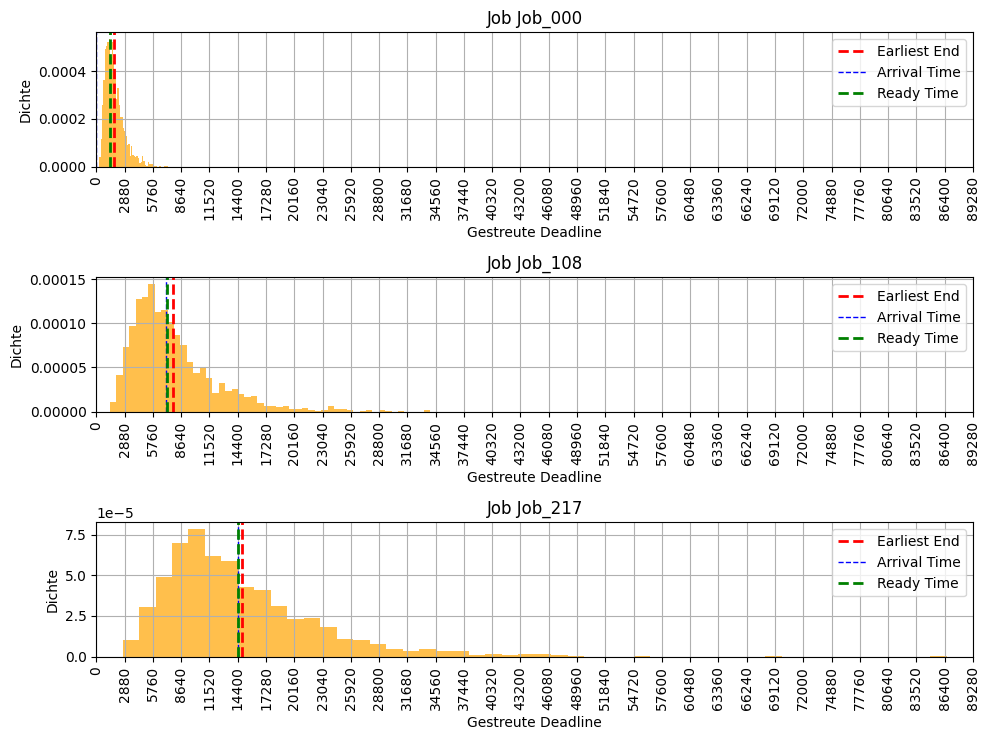

In [8]:
df_times = assign_deadline_lists(df_jobs_times, sigma=0.5, size=2000)

plot_random_deadline_distributions(df_times, n=3, steps= 2880)

### II) Log-Normalverteilung 
#### - mit Sigma als frei wählbarer Parameter
#### - min. Deadline = "Earliest End"
#### - Modus (der häufigste Wert) = "Earliest End" + basic_slack

In [9]:
def assign_log_normal_deadlines_with_mode(df, sigma=0.5, basic_slack=0, seed=50):
    """
    Fügt dem DataFrame eine 'Deadline'-Spalte hinzu, basierend auf einer Lognormalverteilung,
    deren Modus auf 'Earliest End' liegt. Die Deadline ist mindestens 'Earliest End' + basic_slack
    und wird aufgerundet.

    Parameter:
    - sigma: Streuung der Lognormalverteilung
    - seed: Zufalls-Seed für Reproduzierbarkeit
    - basic_slack: Minimaler zusätzlicher Puffer zur 'Earliest End'-Zeit (Standard: 0)

    Erwartete Spalten: 'Earliest End', 'Ready Time', 'Processing Time'
    """
    np.random.seed(seed)

    min_deadlines = df["Earliest End"]
    basic_deadlines = df["Earliest End"] + basic_slack

    log_means = np.log(basic_deadlines) + sigma**2  # damit Modus = Earliest End + basic_slack
    sampled_deadlines = np.random.lognormal(mean=log_means, sigma=sigma)
    deadlines = np.ceil(np.maximum(sampled_deadlines, min_deadlines))

    df = df.copy()
    df["Deadline"] = deadlines.astype(int)
    return df


In [10]:
assign_log_normal_deadlines_with_mode(df_jobs_times, sigma=0.5, basic_slack=90, seed=12)

,Job,Arrival,Ready Time,Processing Time,Earliest End,Deadline
0,Job_000,0,1440,395,1835,3132
1,Job_001,48,1440,510,1950,1950
2,Job_002,113,1440,568,2008,3042
3,Job_003,157,1440,655,2095,2095
4,Job_004,198,1440,393,1833,3599
...,...,...,...,...,...,...
213,Job_213,14045,14400,416,14816,17170
214,Job_214,14107,14400,540,14940,14940
215,Job_215,14297,14400,510,14910,14910
216,Job_216,14360,14400,568,14968,14968


In [11]:
import numpy as np
import pandas as pd

def assign_deadline_lists_with_mode(df, sigma=0.5, basic_slack=0, seed=41, size=1000):
    """
    Fügt dem DataFrame eine Spalte 'Deadline_List' hinzu. Jede Zeile enthält eine Liste
    von 'size' lognormalverteilten Werten mit einem Modus bei 'Earliest End + basic_slack'.

    Die Werte werden aufgerundet und haben einen Mindestwert von 'Earliest End'.

    Parameter:
    - df: DataFrame mit Spalte 'Earliest End'
    - sigma: Streuung der Lognormalverteilung
    - basic_slack: Puffer zum Verschieben des Modus
    - seed: Zufalls-Seed
    - size: Anzahl der Samples pro Job

    Rückgabe:
    - DataFrame mit zusätzlicher Spalte 'Deadline_List'
    """
    np.random.seed(seed)
    df = df.copy()

    deadline_lists = []
    for i in range(len(df)):
        earliest_end = df.loc[i, "Earliest End"]
        target_mode = earliest_end + basic_slack
        mean = np.log(target_mode) + sigma**2
        samples = np.random.lognormal(mean=mean, sigma=sigma, size=size)
        adjusted_samples = np.ceil(np.maximum(samples, earliest_end))
        deadline_lists.append(list(adjusted_samples))

    df["Deadline_List"] = deadline_lists
    return df


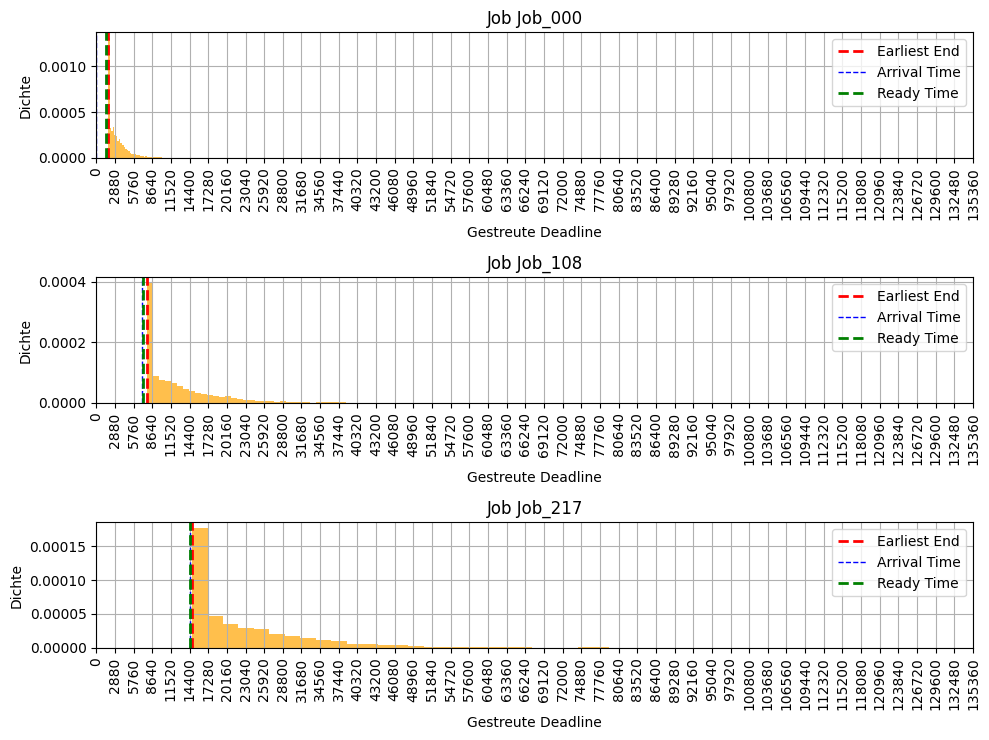

In [12]:
df_times = assign_deadline_lists_with_mode(df_jobs_times, sigma=0.5,basic_slack= 240, size=5000)

plot_random_deadline_distributions(df_times, n=3, steps= 2880)

### IIb) Log-Normalverteilung 
#### - mit Sigma als frei wählbarer Parameter
#### - min. Deadline = "Earliest End"
#### - Modus (der häufigste Wert) = "Earliest End" + basic_slack

In [13]:
import numpy as np
import pandas as pd

def assign_log_normal_deadlines_with_mode(df, sigma=0.5, basic_slack=0, seed=50, log=False):
    """
    Fügt dem DataFrame eine 'Deadline'-Spalte hinzu, basierend auf einer Lognormalverteilung
    mit Modus bei 'Basic Deadline' ('Earliest End + basic_slack'). Es wird bis zu 6-mal ein Wert gezogen.
    Falls kein gültiger Wert >= 'Earliest End' gefunden wird, wird 'Earliest End' genommen.

    Parameter:
    - sigma: Streuung der Lognormalverteilung
    - basic_slack: Minimaler Puffer zum 'Earliest End'
    - seed: Zufalls-Seed für Reproduzierbarkeit

    Erwartete Spalte: 'Earliest End'
    """
    fallback_count = 0
    np.random.seed(seed)
    df = df.copy()
    deadlines = []

    for i in range(len(df)):
        earliest_end = df.loc[i, "Earliest End"]
        basic_deadline = earliest_end + basic_slack
        mean = np.log(basic_deadline) + sigma**2  # ergibt Modus = basic_deadline

        for _ in range(6):
            sample = np.random.lognormal(mean=mean, sigma=sigma)
            if sample >= earliest_end:
                deadlines.append(int(np.ceil(sample)))
                break
        else:
            # Wenn nach 6 Versuchen kein gültiger Wert → Fallback
            deadlines.append(int(np.ceil(earliest_end)))
            fallback_count += 1
    
    if fallback_count > 0 and log == True:
        print(f"Fallback count: {fallback_count}")

    df["Deadline"] = deadlines
    return df

In [14]:
df_with_deadlines = assign_log_normal_deadlines_with_mode(df_jobs_times, sigma=0.5, basic_slack=0, log=True)
df_with_deadlines

,Job,Arrival,Ready Time,Processing Time,Earliest End,Deadline
0,Job_000,0,1440,395,1835,2320
1,Job_001,48,1440,510,1950,5073
2,Job_002,113,1440,568,2008,2032
3,Job_003,157,1440,655,2095,4594
4,Job_004,198,1440,393,1833,2508
...,...,...,...,...,...,...
213,Job_213,14045,14400,416,14816,28593
214,Job_214,14107,14400,540,14940,20670
215,Job_215,14297,14400,510,14910,49131
216,Job_216,14360,14400,568,14968,32189


In [15]:
import numpy as np
import pandas as pd

def assign_log_normal_deadline_lists_with_mode(df, sigma=0.5, basic_slack=0, seed=50, size=1000):
    """
    Fügt dem DataFrame eine Spalte 'Deadline_List' hinzu, bestehend aus lognormalverteilten Deadlines.
    Jede Liste enthält 'size' Deadlines, deren Modus auf 'Earliest End + basic_slack' liegt.
    Jeder Wert wird bis zu 6-mal gezogen. Falls keiner gültig ist (sample >= earliest_end), wird 'earliest_end' genommen.

    Parameter:
    - sigma: Streuung der Lognormalverteilung
    - basic_slack: Minimaler Puffer zum 'Earliest End'
    - seed: Zufalls-Seed für Reproduzierbarkeit
    - size: Anzahl der Deadlines pro Job

    Erwartete Spalte: 'Earliest End'
    """
    np.random.seed(seed)
    df = df.copy()
    deadline_lists = []

    for i in range(len(df)):
        earliest_end = df.loc[i, "Earliest End"]
        basic_deadline = earliest_end + basic_slack
        mean = np.log(basic_deadline) + sigma**2
        deadlines = []

        for _ in range(size):
            for _ in range(6):
                sample = np.random.lognormal(mean=mean, sigma=sigma)
                if sample >= earliest_end:
                    deadlines.append(int(np.ceil(sample)))
                    break
            else:
                deadlines.append(int(np.ceil(earliest_end)))

        deadline_lists.append(deadlines)

    df["Deadline_List"] = deadline_lists
    return df


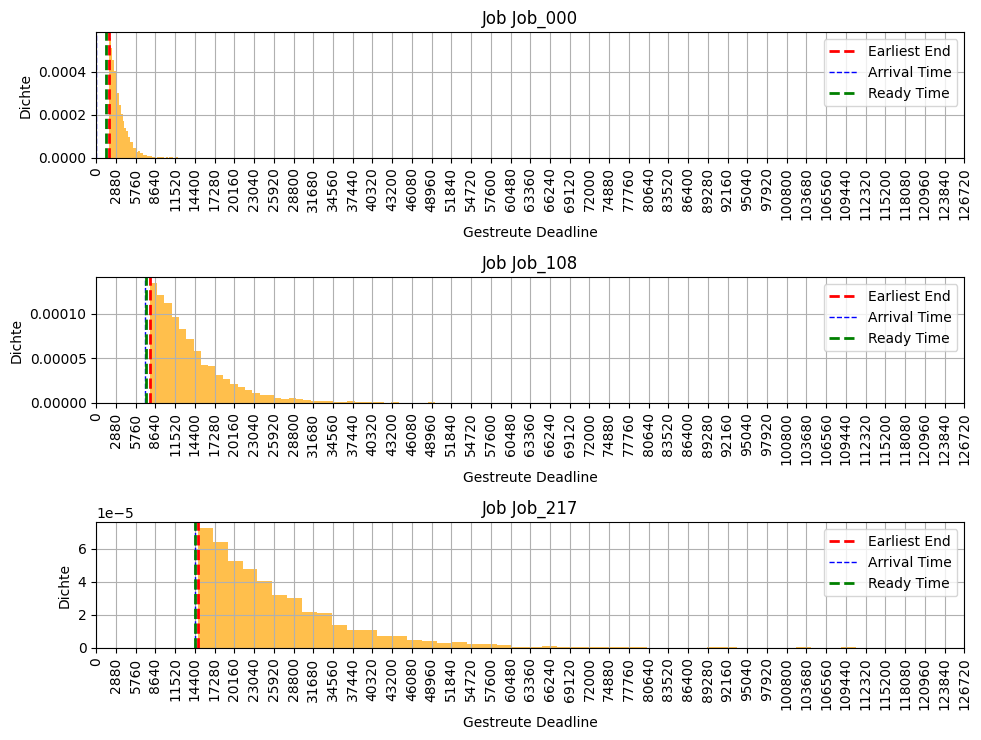

In [16]:
df = assign_log_normal_deadline_lists_with_mode(df_jobs_times, sigma=0.5, basic_slack= 0, size=5000)
plot_random_deadline_distributions(df, n=3, steps= 2880)

### III) Log-Normalverteilung mit manuell festgelegtem globalen Modus

#### Eigenschaften:
- **Frei wählbares Sigma**: bestimmt die **globale Streuung** der Verteilung
- **Global definierter Modus**: die zugrunde liegende Log-Normalverteilung hat  
  ihren Modus bei einem **festgelegten Wert** wie z. B. *2880 Minuten*
- **Modusverschiebung je Job**: jeder gezogene Wert wird individuell verschoben, sodass der  
  Modus pro Job genau **Earliest End + basic_slack** ist
- **Minimale Deadline**: jeder gezogene Wert wird verworfen, wenn er kleiner als *Earliest End*  
  ist (bis zu 6 Ziehungen), sonst wird *Earliest End* als Fallback gesetzt

#### Vorteil:
- Die Streuung ist **über alle Jobs konstant und unabhängig von den Werten**
- Eignet sich besonders für kontrollierte Simulationen, bei denen ein gemeinsamer Unsicherheitsrahmen gewünscht ist
- Der Modus kann bewusst so gewählt werden, dass er einer gewünschten Planungszeitspanne entspricht (z. B. 2 Tage = 2880 Minuten)

In [17]:
import numpy as np
import pandas as pd

def assign_deadlines_with_global_lognormal_mode(df, sigma=0.5, basic_slack=0, seed=50, global_modus=2880, log=False):
    """
    Deadline-Samples basieren auf einer globalen Lognormalverteilung.
    Der globale Modus ist standardmäßig 2880 oder kann explizit übergeben werden.

    Jeder Sample wird individuell so verschoben, dass der Modus pro Job = Earliest End + basic_slack ist.

    Parameter:
    - sigma: Streuung der Lognormalverteilung
    - basic_slack: Puffer zum 'Earliest End'
    - global_modus: fixer Modus der Verteilung vor Verschiebung (Standard: 2880)
    - seed: Zufalls-Seed
    - log: ob Anzahl der Fallbacks ausgegeben wird
    """
    fallback_count = 0
    np.random.seed(seed)
    df = df.copy()
    deadlines = []

    log_mean = np.log(global_modus) + sigma**2  # ergibt Modus = global_modus

    for i in range(len(df)):
        earliest_end = df.loc[i, "Earliest End"]
        basic_deadline = earliest_end + basic_slack

        for _ in range(6):
            sample = np.random.lognormal(mean=log_mean, sigma=sigma)
            shifted_sample = sample - global_modus + basic_deadline
            if shifted_sample >= earliest_end:
                deadlines.append(int(np.ceil(shifted_sample)))
                break
        else:
            deadlines.append(int(np.ceil(earliest_end)))
            fallback_count += 1

    if fallback_count > 0 and log:
        print(f"Fallback count: {fallback_count}")

    df["Deadline"] = deadlines
    return df


In [18]:
df_with_deadlines = assign_deadlines_with_global_lognormal_mode(df_jobs_times, sigma=0.2, basic_slack=0, log=True)
df_with_deadlines.head(20)

Fallback count: 1


,Job,Arrival,Ready Time,Processing Time,Earliest End,Deadline
0,Job_000,0,1440,395,1835,1935
1,Job_001,48,1440,510,1950,3046
2,Job_002,113,1440,568,2008,2842
3,Job_003,157,1440,655,2095,2290
4,Job_004,198,1440,393,1833,2515
5,Job_005,401,1440,496,1936,2502
6,Job_006,681,1440,416,1856,3104
7,Job_007,810,1440,539,1979,4915
8,Job_008,870,1440,597,2037,2810
9,Job_009,885,1440,540,1980,2173


In [19]:
import numpy as np
import pandas as pd

def assign_deadline_lists_with_global_lognormal_mode(df, sigma=0.5, basic_slack=0, global_modus=2880, seed=50, size=1000, log=False):
    """
    Fügt dem DataFrame eine Spalte 'Deadline_List' hinzu, wobei jeder Eintrag aus bis zu 6 Versuchen stammt.
    Die Basis ist eine globale Lognormalverteilung mit konstanter Streuung. Der Modus wird pro Job individuell
    auf 'Earliest End + basic_slack' verschoben.

    Eigenschaften:
    - Konstante Streuung über alle Jobs
    - Globaler Modus der Lognormalverteilung standardmäßig 2880 (z. B. 2 Tage in Minuten)
    - Pro Deadline max. 6 Ziehversuche, sonst Fallback
    """
    np.random.seed(seed)
    df = df.copy()
    fallback_total = 0

    # globale Verteilung vorbereiten
    log_mean = np.log(global_modus) + sigma**2

    all_deadline_lists = []

    for i in range(len(df)):
        earliest_end = df.loc[i, "Earliest End"]
        basic_deadline = earliest_end + basic_slack
        deadline_list = []
        fallback_count = 0

        for _ in range(size):
            for _ in range(6):
                sample = np.random.lognormal(mean=log_mean, sigma=sigma)
                shifted = sample - global_modus + basic_deadline
                if shifted >= earliest_end:
                    deadline_list.append(int(np.ceil(shifted)))
                    break
            else:
                deadline_list.append(int(np.ceil(earliest_end)))
                fallback_count += 1

        fallback_total += fallback_count
        all_deadline_lists.append(deadline_list)

    if fallback_total > 0 and log:
        print(f"Total Fallbacks: {fallback_total}")

    df["Deadline_List"] = all_deadline_lists
    return df


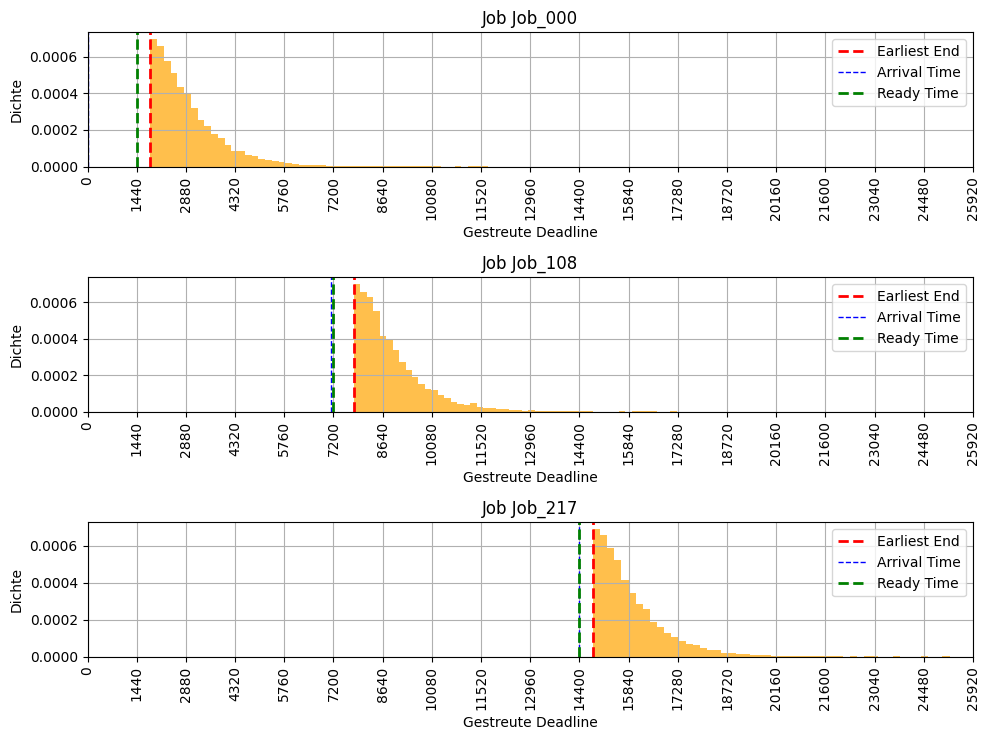

In [20]:
df = assign_deadline_lists_with_global_lognormal_mode(df_jobs_times, sigma=0.5, basic_slack=0, global_modus=1440, size=8000)
plot_random_deadline_distributions(df, n=3)

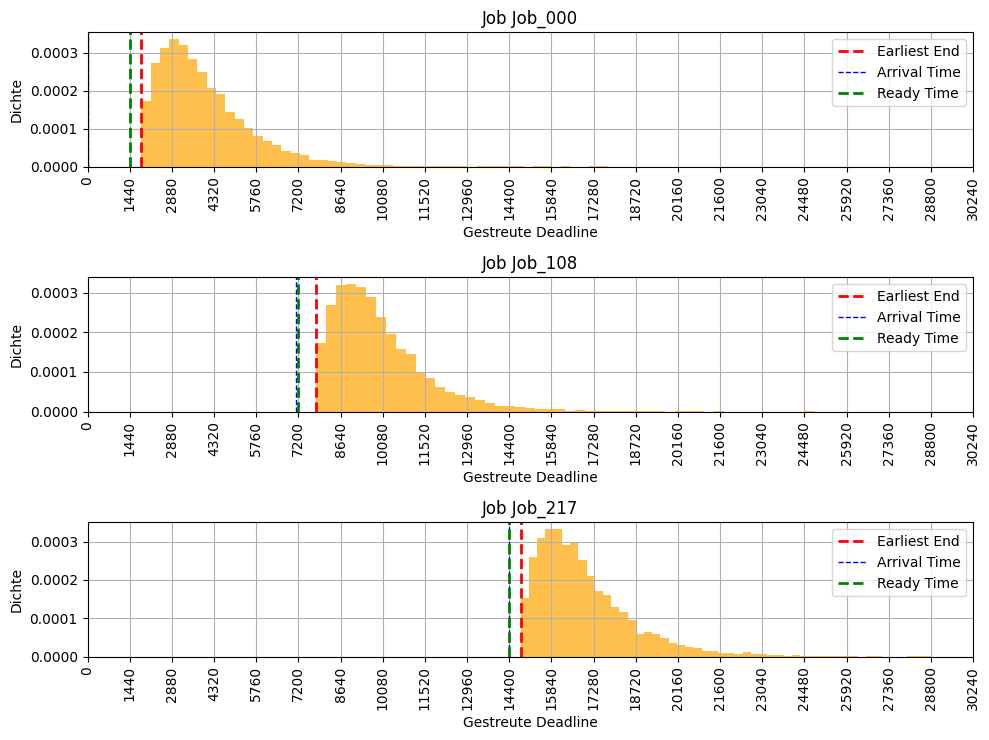

In [21]:
df = assign_deadline_lists_with_global_lognormal_mode(df_jobs_times, sigma=0.5, basic_slack=1080, global_modus=2160, size=8000)
plot_random_deadline_distributions(df, n=3)